In [1]:
import numpy as np
import torch 
import sys
sys.path.append("../")

import tqdm
import yaml
torch.random.manual_seed(300)
import matplotlib.pyplot as plt

import utils_BayOTIDE as utils

from model_BayOTIDE import BayTIDE

from model_LDS import LDS_GP_streaming

config_path = "./config_simu_impute.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

data_file = config["data_path"] 

hyper_dict = utils.make_hyper_dict(config)

data_dict = utils.make_data_dict(hyper_dict,data_file,fold=0)

model = BayTIDE(hyper_dict,data_dict)

# model.post_W_m =   torch.ones(  model.N, model.K, 1,).double().to(model.device)#  (N,K,1) 

model.reset()

INNER_ITER = hyper_dict["INNER_ITER"]
EVALU_T = hyper_dict["EVALU_T"]
for epoch in range(1):
    model.reset()
    for T_id in tqdm.tqdm(range(model.T)):
        model.filter_predict(T_id)
        model.msg_llk_init()

        if model.mask_train[:,T_id].sum()>0: # at least one obseved data at current step
            for inner_it in range(INNER_ITER):

                flag = (inner_it == (INNER_ITER - 1))

                model.msg_approx_U(T_id)
                model.filter_update(T_id,flag)

                model.msg_approx_W(T_id)
                model.post_update_W(T_id)



            model.msg_approx_tau(T_id)
            model.post_update_tau(T_id)

        else:
            model.filter_update_fake(T_id)
        if T_id % EVALU_T == 0 or T_id == model.T - 1:
            
            pred, loss_dict = model.model_test(T_id)
            print("T_id = {}, train_rmse = {:.2f}, test_rmse= {:.2f}".format(T_id, loss_dict["train_RMSE"], loss_dict["test_RMSE"]))

    model.smooth()
    model.post_update_U_after_smooth(0)
    pred, loss_dict = model.model_test(T_id)
    print("after smooth, train_rmse = {:.2f}, test_rmse= {:.2f},  test_MAE= {:.2f}".format(loss_dict["train_RMSE"] ,loss_dict["test_RMSE"], loss_dict["test_MAE"]))



use device: cpu


  0%|          | 0/500 [00:00<?, ?it/s]/home/venus/fang/BayTIDE/notebook/../model_LDS.py:252: UserWarning: An output with one or more elements was resized since it had shape [1, 2, 2], which does not match the required output shape [1, 1, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/Resize.cpp:17.)
  self.A = torch.matrix_exp(self.F * time_int).double()
  9%|▉         | 46/500 [00:00<00:01, 449.76it/s]

T_id = 0, train_rmse = 4.68, test_rmse= 4.66


 29%|██▊       | 143/500 [00:00<00:00, 748.89it/s]

T_id = 100, train_rmse = 4.88, test_rmse= 4.89


 48%|████▊     | 241/500 [00:00<00:00, 853.06it/s]

T_id = 200, train_rmse = 5.63, test_rmse= 5.60
T_id = 300, train_rmse = 5.54, test_rmse= 5.40


 70%|███████   | 350/500 [00:00<00:00, 945.94it/s]

T_id = 400, train_rmse = 4.31, test_rmse= 4.21


100%|██████████| 500/500 [00:00<00:00, 950.05it/s] 
/home/venus/fang/BayTIDE/notebook/../model_LDS.py:310: UserWarning: An output with one or more elements was resized since it had shape [1, 2, 2], which does not match the required output shape [1, 1, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/Resize.cpp:17.)
  A = torch.matrix_exp(self.F * time_int)


T_id = 499, train_rmse = 0.63, test_rmse= 0.75
after smooth, train_rmse = 0.30, test_rmse= 0.32,  test_MAE= 0.25


In [2]:
model.E_tau

tensor(0.5193, dtype=torch.float64)

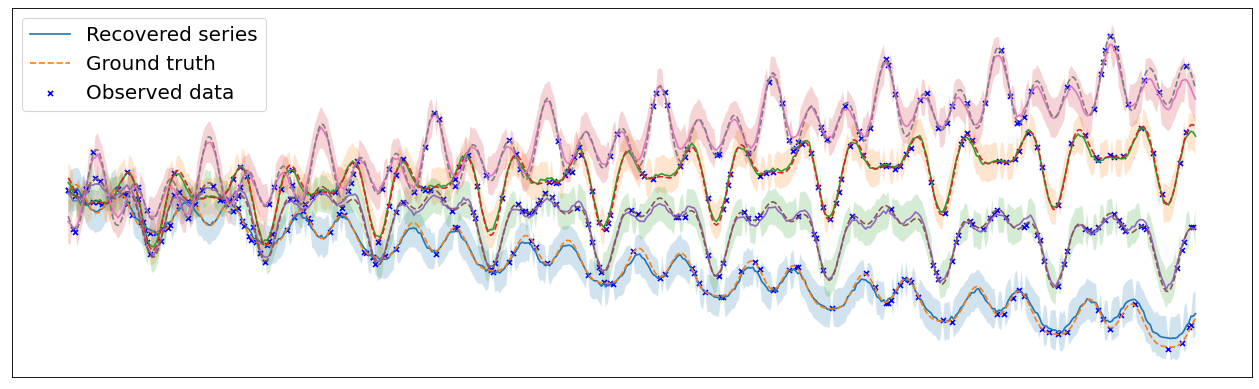

In [37]:


clean_data = data_dict['clean_data']

plt.figure(figsize=(20, 6), dpi=80)
# plt.figure(figsize=(33, 22), dpi=80)
# use for loop to plot
for i in range(4):
#     # plt.plot(pred[i,:].detach().numpy(), label = "pred-0")

    sample_X = model.pred_sample(nsample_=300, add_tau = True)

    pred_mean = sample_X.mean(dim = 0)
    pred_std = sample_X.std(dim = 0)

    train_mask_K = model.mask_test[i,:].detach().numpy()
    uncernt = pred_std[i,:].detach().numpy() * train_mask_K

    if i ==0: 

        plt.plot(pred_mean[i,:].detach().numpy(),linestyle = '-', label = "Recovered series".format(i+1))
        plt.fill_between(np.arange(model.T), pred_mean[i,:].detach().numpy() - 1 *  uncernt, pred_mean[i,:].detach().numpy() + 1 *  uncernt, alpha=0.2)

        plt.plot(clean_data[i,:] ,linestyle = '--', label = "Ground truth".format(i+1))
    else: 
        plt.plot(pred_mean[i,:].detach().numpy(),linestyle = '-',)
        plt.fill_between(np.arange(model.T), pred_mean[i,:].detach().numpy() - 1 *  uncernt, pred_mean[i,:].detach().numpy() + 1 *  uncernt, alpha=0.2, )

        plt.plot(clean_data[i,:] ,linestyle = '--')

for T in range(model.T):
    for K in range(model.K):
        if model.mask_train[K,T] > 0:
            # set the size of the scatter to zero

            plt.scatter(T, model.data[K,T].detach().numpy(), marker = "x", color = "blue", s=20)
    #     plt.plot(model.post_U_m[T,K,:].detach().numpy(), label = "U-{}-{}".format(T,K), alpha = 0.5)
    # # scatter the observation based on mask_train
    # plt.scatter(np.arange(model.T)[model.mask_train[i,:].detach().numpy()], model.data[i,model.mask_train[i,:]].detach().numpy(), label = "observed-{}".format(i), marker = "x", color = "red")
plt.scatter(0, model.data[0,0].detach().numpy(), marker = "x", color = "blue", s=20, label = "Observed data")



# plt.xticks(np.array([0,200,400,500]),fontsize=25)
plt.xticks([])
plt.yticks([])


# set y axis as -15,0,15
# plt.yticks(np.array([-15,0,15]),fontsize=25)


# adjust the legend size
plt.legend(fontsize=18)



# set X axis size

# 

# set Y ticks



# save as pdf
plt.savefig("./figs/fig_simu_impute.pdf", bbox_inches='tight')
# save as png
plt.savefig("./figs/fig_simu_impute.png", bbox_inches='tight')



(4, 500)
(4, 4, 500)


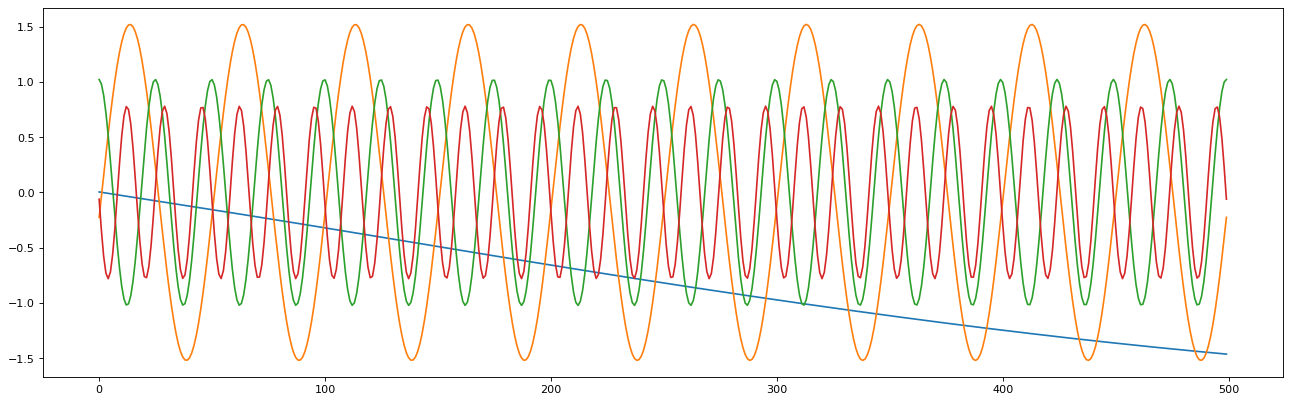

In [9]:
post_U_m = model.post_U_m.detach().numpy().squeeze()
post_U_v = model.post_U_v.detach().numpy()

# check shape

print(post_U_m.shape)
print(post_U_v.shape)

# check the first 20 values of post_U by ploting

target_factor_idx =0



x = np.arange(model.T)

plt.figure(figsize=(20, 6), dpi=80)
M,_ = post_U_m.shape

for target_factor_idx in range(M):



    plt.plot(x, post_U_m[target_factor_idx,:])
    # plt.fill_between(x, post_U_m[target_factor_idx,:] - 2 * np.sqrt(post_U_v[target_factor_idx,target_factor_idx,:]), post_U_m[target_factor_idx,:] + 2 * np.sqrt(post_U_v[target_factor_idx,target_factor_idx,:]), alpha=0.2)




In [6]:
data_dict['weight']

array([[ 1. ,  1. ,  1. ,  0.5],
       [-0.4,  1. ,  2. , -1. ],
       [ 0.3,  2. ,  1. , -1. ],
       [-1. ,  1. , -1. , -2. ]])

In [7]:
model.post_W_m

tensor([[[ 6.3714],
         [ 0.5849],
         [ 0.9030],
         [-0.4725]],

        [[-2.5780],
         [ 0.6143],
         [ 1.8269],
         [ 1.2944]],

        [[ 1.9342],
         [ 1.1723],
         [ 1.0631],
         [ 1.2326]],

        [[-6.3928],
         [ 0.7430],
         [-0.8823],
         [ 2.0223]]], dtype=torch.float64)

(4, 500)
(4, 4, 500)


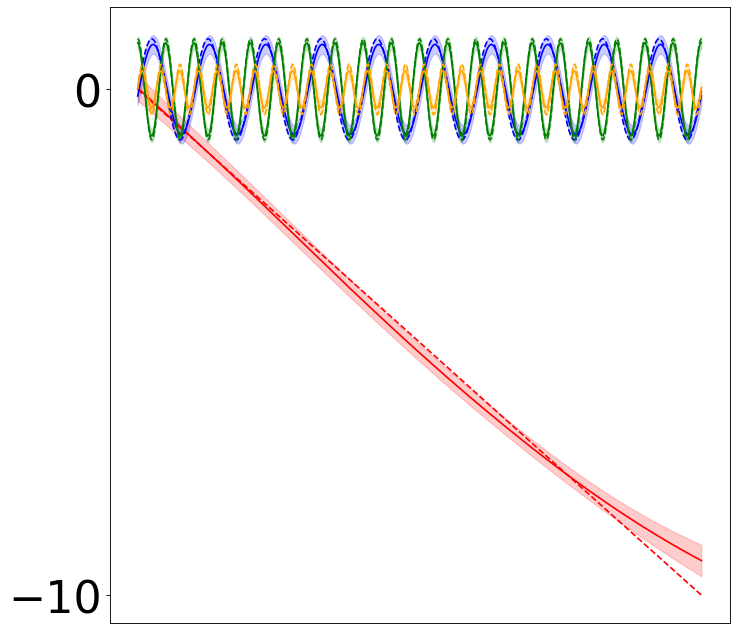

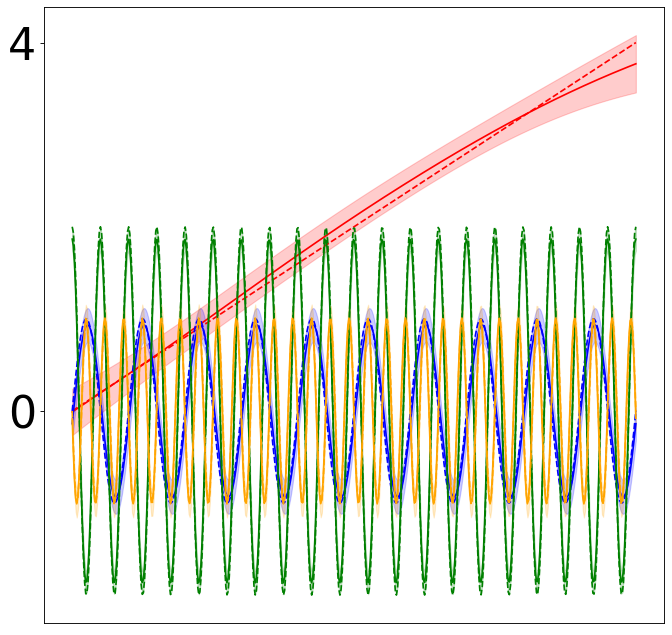

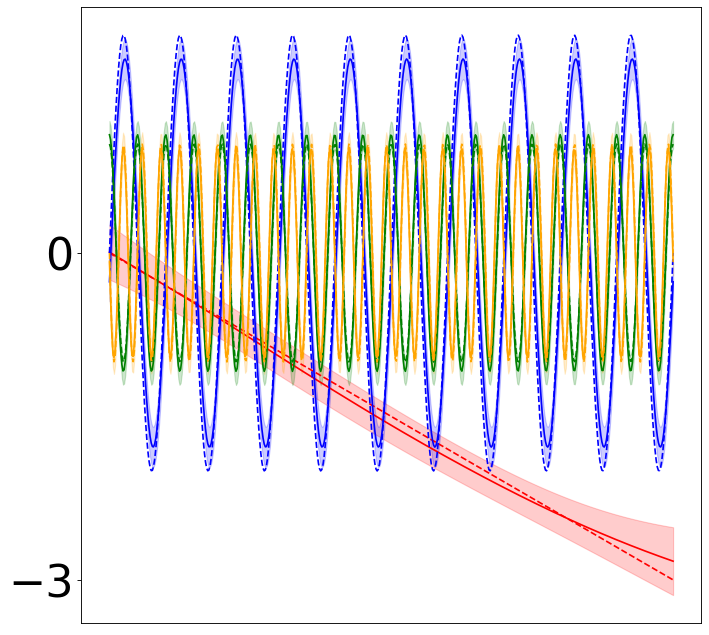

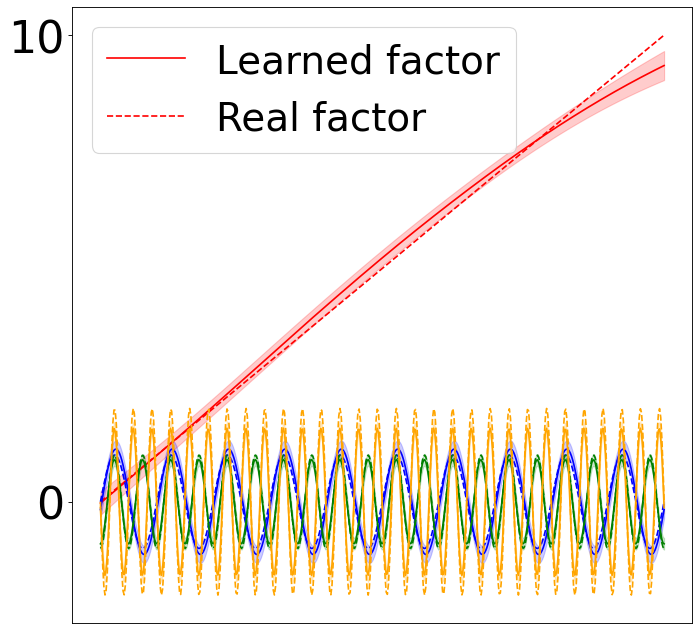

In [44]:
min_max_pair = [(0, -10), (0, 4), (0,-3), (0, 10)]

post_U_m = model.post_U_m.detach().numpy().squeeze()
post_U_v = model.post_U_v.detach().numpy()

weight_true = data_dict['weight']

# check shape

print(post_U_m.shape)
print(post_U_v.shape)

# check the first 20 values of post_U by ploting


N =0 # the # of sub-seq to plot
x = np.arange(model.T)
t = np.linspace(0, 1, model.T)


M,_ = post_U_m.shape

true_factor = [ lambda x: -10*x, lambda x: 1*np.sin(20*np.pi*x), lambda x:1 *np.cos(40*np.pi*x),lambda x: 1*np.sin(60*np.pi*x)]

color_list = ['red', 'blue', 'green', 'orange']

for N in range(4):

    plt.figure(figsize=(10, 10), dpi=80)
    
    for target_factor_idx in range(M):

        weight = model.post_W_m.detach().numpy().squeeze()[N, target_factor_idx]
        weight_real = weight_true[N, target_factor_idx]

        if target_factor_idx == 0:
            plt.plot(x, post_U_m[target_factor_idx,:] * weight ,label='Learned factor', color = color_list[target_factor_idx],linestyle = '-' ,)

            plt.plot(x, true_factor[target_factor_idx](t)  * weight_real,label= 'Real factor', color = color_list[target_factor_idx],linestyle = '--')

            Y_min = np.min(post_U_m[target_factor_idx,:] * weight)
            Y_max = np.max(post_U_m[target_factor_idx,:] * weight)

        else:
            plt.plot(x, post_U_m[target_factor_idx,:] * weight , color = color_list[target_factor_idx],linestyle = '-' ,)

            plt.plot(x, true_factor[target_factor_idx](t)  * weight_real, color = color_list[target_factor_idx],linestyle = '--')
            # plt.plot(x, post_U_m[target_factor_idx,:] * weight ,label='Learned factor: season-{}'.format(target_factor_idx), color = color_list[target_factor_idx],linestyle = '-' ,)

            # plt.plot(x, true_factor[target_factor_idx](t)  * weight_real,label= 'Real factor: season-{}'.format(target_factor_idx), color = color_list[target_factor_idx],linestyle = '--')

        plt.fill_between(x, post_U_m[target_factor_idx,:]* weight - 2 * np.sqrt(post_U_v[target_factor_idx,target_factor_idx,:]), post_U_m[target_factor_idx,:] * weight+ 2 * np.sqrt(post_U_v[target_factor_idx,target_factor_idx,:]), alpha=0.2, color = color_list[target_factor_idx])



    # remove the ticks of x, y axis
    plt.xticks([])
    # plt.yticks([])
    y_min, y_max = min_max_pair[N]
    plt.yticks([y_min, y_max],fontsize=40)

    if N == 3:
        plt.legend(fontsize=35)
    # plt.legend()

    # save as pdf
    plt.savefig("./figs/fig_simu_factor_{}.pdf".format(N), bbox_inches='tight')





